In [1]:
import os
import sys
import math
import random

from datetime import datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as ex
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import plotly.offline as pyo

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.classifier import ROCAUC
from yellowbrick.style import set_palette

from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm_nb

import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
df = pd.read_csv("../input/file-format-detection/dataset.csv")
df

,id,file_path,file_size,line_count,extension,language
0,1,Markdown/000001.md,34784,572,md,Markdown
1,2,XML/000002.props,3013,44,props,XML
2,3,Text/000003.txt,1076,21,txt,Text
3,4,Markdown/000004.md,8105,84,md,Markdown
4,5,Markdown/000005.md,2763,41,md,Markdown
...,...,...,...,...,...,...
86222,86229,SQL/086229.sql,333,18,sql,SQL
86223,86230,SQL/086230.sql,420,8,sql,SQL
86224,86231,SQL/086231.sql,333,18,sql,SQL
86225,86232,SQL/086232.sql,420,8,sql,SQL


In [3]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,86227.0,43114.018927,24891.767750,1.0,21557.5,43114.0,64670.5,86233.0
file_size,86227.0,13460.083350,288525.459138,0.0,438.0,1386.0,4466.5,27009979.0
line_count,86227.0,256.502314,4910.110760,0.0,18.0,45.0,127.0,580544.0


In [4]:
df.describe(include="O").T

,count,unique,top,freq
file_path,86227,86227,Markdown/000001.md,1
extension,86227,129,dart,15345
language,86227,77,Dart,15345


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86227 entries, 0 to 86226
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          86227 non-null  int64 
 1   file_path   86227 non-null  object
 2   file_size   86227 non-null  int64 
 3   line_count  86227 non-null  int64 
 4   extension   86227 non-null  object
 5   language    86227 non-null  object
dtypes: int64(3), object(3)
memory usage: 3.9+ MB


In [6]:
df_ext_count = df.groupby('extension').count().sort_values(by='id')

ex.pie(df_ext_count.index[-30:],names='extension',title='Propotion Of Different Extension',hole=0.33)

In [7]:
fig = ex.bar(df_ext_count, x=df_ext_count.index[-30:], y=df_ext_count['id'][-30:])
fig.show();

In [8]:
df_leng_count = df.groupby('language').count().sort_values(by='id')


ex.pie(df_leng_count.index[-30:],names='language',title='Propotion Of Different Language',hole=0.33)

In [9]:
fig = ex.bar(df_leng_count, x=df_leng_count.index[-30:], y=df_leng_count['id'][-30:])
fig.show();

In [10]:
df_path_count = df.groupby('file_path').count().sort_values(by='id')


ex.pie(df_path_count.index[-30:],names='file_path',title='Propotion Of Different File Path',hole=0.33)

In [11]:
fig = ex.bar(df_path_count, x=df_path_count.index[-30:], y=df_path_count['id'][-30:])
fig.show()

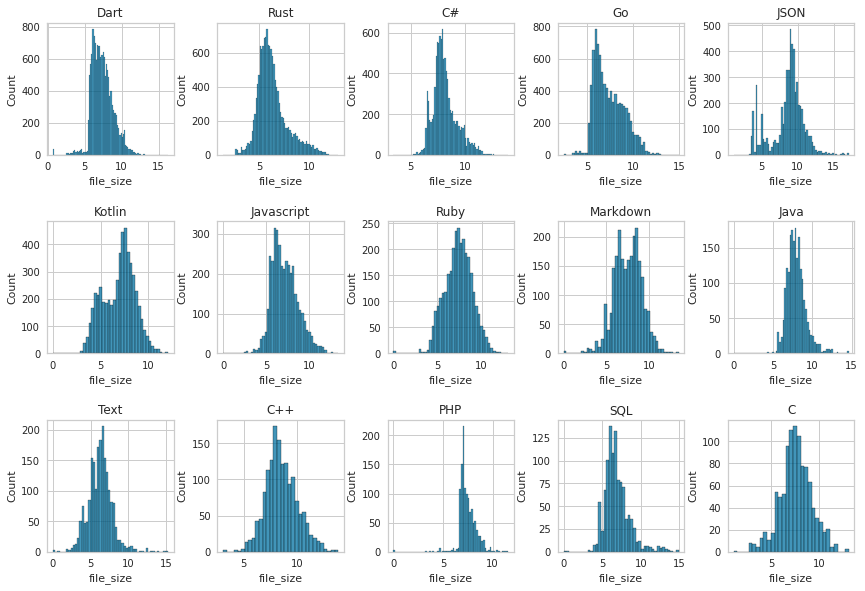

In [12]:
df_size_count = df.groupby('language').count().sort_values(by='file_size')


fig, axes = plt.subplots(3, 5, figsize=(12, 8))
plt.tight_layout()
plt.subplots_adjust(hspace=0.5)
langs = list(df_size_count.index[-15:])[::-1]

for i, lang in enumerate(langs):
    if i >= axes.shape[0] * axes.shape[1]: break
    r, c = i // 5, i % 5
    axes[r][c].set_title(lang)
    sns.histplot(df[df.language == lang]['file_size'].apply(np.log1p), ax=axes[r][c], palette="summer")

plt.show();

In [13]:
languages = list(df_leng_count[df_leng_count > 500].dropna().index)
print('Train and predict for only:', languages)

Train and predict for only: ['YAML', 'Elixir', 'GAS', 'GLSL', 'Julia', 'Diff', 'C', 'SQL', 'PHP', 'C++', 'Text', 'Java', 'Markdown', 'Ruby', 'Javascript', 'Kotlin', 'JSON', 'Go', 'C#', 'Rust', 'Dart']


In [14]:
def get_content(file_path):
    path = os.path.join('../input/file-format-detection/dataset', file_path)
    encodings = ['utf-8', 'cp949']
    for enc in encodings:
        try:
            f = open(path, 'r', encoding=enc)
            ret = '\n'.join(list(map(lambda s: s.rstrip(), f.readlines())))
            f.close()
            return ret
        except UnicodeDecodeError:
            continue
        except:
            break
        finally:
            if f != None: f.close()
    return None

def add_file_content(df):
    contents = []
    for i, row in tqdm_nb(df.iterrows(), total=len(df), desc='read files'):
        contents.append(get_content(row['file_path']))
    df['file_content'] = contents
    return df

In [15]:
df = add_file_content(df[df.language.isin(languages)].sample(frac=0.5))
df = df.dropna()
df

read files:   0%|          | 0/40773 [00:00<?, ?it/s]

,id,file_path,file_size,line_count,extension,language,file_content
24619,24620,Dart/024620.dart,891,33,dart,Dart,"// Copyright (c) 2019, the Dart project author..."
75742,75743,Rust/075743.rs,139,6,rs,Rust,#![feature(rustc_attrs)]\n\n#[rustc_legacy_con...
2578,2579,JSON/002579.json,2395,65,json,JSON,"{\n ""Entries"": [\n {\n ""RequestUri"": ..."
41868,41869,Go/041869.go,1088,47,go,Go,// Copyright 2009 The Go Authors. All rights r...
26280,26281,Dart/026281.dart,366,7,dart,Dart,"// Copyright (c) 2021, the Dart project author..."
...,...,...,...,...,...,...,...
15291,15292,JSON/015292.json,9719,196,json,JSON,"﻿{\n ""Entries"": [\n {\n ""RequestUri"":..."
21585,21586,Dart/021586.dart,5088,146,dart,Dart,"// Copyright (c) 2019, the Dart project author..."
7749,7750,C#/007750.cs,48335,1036,cs,C#,// <auto-generated>\n// Copyright (c) Microsof...
64216,64217,Ruby/064217.rb,2080,78,rb,Ruby,"# frozen_string_literal: true\n\nrequire ""isol..."


In [16]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

vectorizer = CountVectorizer()
vectors = vectorizer.fit_transform(df['file_content'])

CPU times: user 39.4 s, sys: 717 ms, total: 40.1 s
Wall time: 40.2 s


In [17]:
x_train, x_test, y_train, y_test = train_test_split(vectors, df['language'], test_size = 0.33, random_state = 42)

print(x_train.shape, y_train.shape)

(27310, 2226466) (27310,)


In [18]:
r_forest = RandomForestClassifier()
r_forest.fit(x_train,y_train)
predicted = r_forest.predict(x_test)
score = r_forest.score(x_test, y_test)
rf_score_ = np.mean(score)

print('Accuracy : %.3f' % (rf_score_))

Accuracy : 0.962


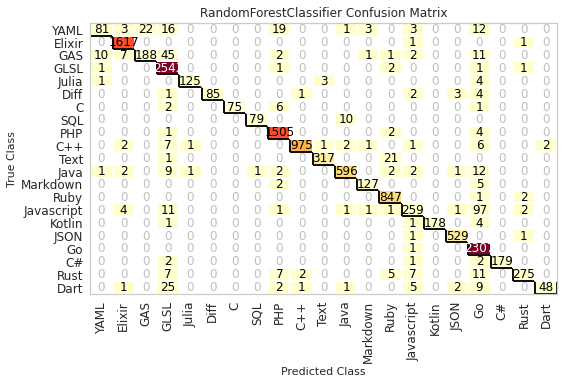

<AxesSubplot:title={'center':'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [19]:
r_forest_cm = ConfusionMatrix(r_forest, classes=['YAML', 'Elixir', 'GAS', 'GLSL', 'Julia', 'Diff', 'C', 'SQL', 'PHP', 
                                                 'C++', 'Text', 'Java', 'Markdown', 'Ruby', 'Javascript', 'Kotlin', 'JSON', 'Go', 'C#', 'Rust', 'Dart'])

r_forest_cm.fit(x_train, y_train)
r_forest_cm.score(x_test, y_test)
r_forest_cm.show()

In [20]:
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           C       0.86      0.51      0.64       160
          C#       0.99      1.00      0.99      1619
         C++       0.90      0.70      0.79       267
        Dart       0.95      1.00      0.97      2549
        Diff       0.98      0.94      0.96       133
      Elixir       1.00      0.89      0.94        96
         GAS       1.00      0.89      0.94        84
        GLSL       0.99      0.89      0.93        89
          Go       0.97      1.00      0.98      1512
        JSON       1.00      0.98      0.99       998
        Java       0.99      0.94      0.96       339
  Javascript       0.98      0.95      0.96       629
       Julia       0.95      0.95      0.95       134
      Kotlin       0.96      1.00      0.98       850
    Markdown       0.91      0.69      0.78       378
         PHP       1.00      0.97      0.98       184
        Ruby       0.99      1.00      0.99       531
        Rust       0.93    

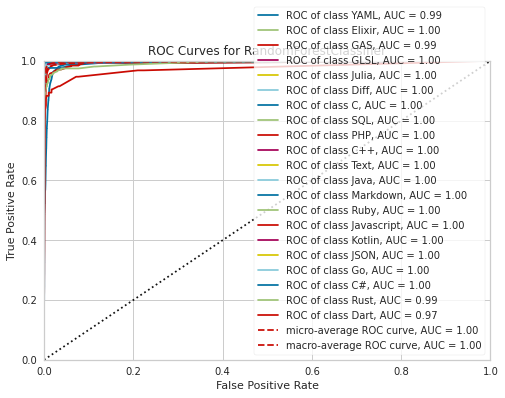

<AxesSubplot:title={'center':'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [21]:
visualizer = ROCAUC(r_forest, classes=['YAML', 'Elixir', 'GAS', 'GLSL', 'Julia', 'Diff', 'C', 'SQL', 'PHP', 
                                       'C++', 'Text', 'Java', 'Markdown', 'Ruby', 'Javascript', 'Kotlin', 'JSON', 'Go', 'C#', 'Rust', 'Dart'])

visualizer.fit(x_train, y_train)       
visualizer.score(x_test, y_test)        
visualizer.show()  

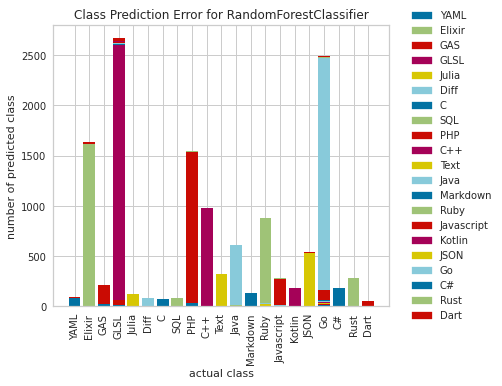

<AxesSubplot:title={'center':'Class Prediction Error for RandomForestClassifier'}, xlabel='actual class', ylabel='number of predicted class'>

In [22]:
visualizer = ClassPredictionError(r_forest, classes=['YAML', 'Elixir', 'GAS', 'GLSL', 'Julia', 'Diff', 'C', 'SQL', 'PHP', 
                                                     'C++', 'Text', 'Java', 'Markdown', 'Ruby', 'Javascript', 'Kotlin', 'JSON', 'Go', 'C#', 'Rust', 'Dart'])

visualizer.fit(x_train, y_train)        
visualizer.score(x_test, y_test)        
visualizer.show()   